In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic - Machine Learning from Disaster

Is it possible to predict whether someone will survive a given disaster? That is the question we'll try to answer.

Here, we'll be using the example of the Titanic and its passengers. 

## Let's load the data

# Explanations for the columns of our dataset:

**Variable**	Definition	Key
**survival**	Survival	0 = No, 1 = Yes
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
**Parent** = mother, father
**Child** = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(titanic_train.shape)
display(titanic_train)


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We can see that there are 11 features and we are trying to predict the survived column. 

Some columns like Age and Cabin seem to cointain NaN values which is a problem. We'll have to make sure to remove the corresponding lines.

The ticket number doesn't give much information since we already have the fare and the cabin. Thus, we can delete this column.
Same goes for the Name column

We'll use one-hot vectors for Sex and Embarked 





# Data Preparation

In [3]:
#First we are going to remove useless columns

titanic_train = titanic_train.drop(['Name', 'Ticket'], axis = 1)

titanic_test = titanic_test.drop(['Name', 'Ticket'], axis = 1)
#Next we remove NaN values.
#Let's count them:
print(titanic_train.isnull().sum(axis = 0))
print(titanic_test.isnull().sum(axis = 0))

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
dtype: int64


We can see that there are many missing values for the cabin numbers,we can drop that column.
We can also remove the examples for which there is no age.

In [4]:
titanic_train = titanic_train.drop(['Cabin'], axis = 1)

titanic_test = titanic_test.drop(['Cabin'], axis = 1)

#titanic_train = titanic_train.dropna()
#titanic_test = titanic_test.dropna()
titanic_train = titanic_train.fillna(0)
titanic_test = titanic_test.fillna(0)

In [5]:
display(titanic_train)
display(titanic_test)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,0.0,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,0.0,0,0,8.0500,S
414,1306,1,female,39.0,0,0,108.9000,C
415,1307,3,male,38.5,0,0,7.2500,S
416,1308,3,male,0.0,0,0,8.0500,S


Now we use one-hot encoding for the Sex and Embarked column

In [6]:
titanic_train = pd.get_dummies(titanic_train,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])
titanic_test = pd.get_dummies(titanic_test,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])
display(titanic_train)
display(titanic_test)
titanic_train = titanic_train.drop('Embarked_0', axis=1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_0,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,1,0,0,0,1
887,888,1,1,19.0,0,0,30.0000,1,0,0,0,0,1
888,889,0,3,0.0,1,2,23.4500,1,0,0,0,0,1
889,890,1,1,26.0,0,0,30.0000,0,1,0,1,0,0


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,1,0
1,893,3,47.0,1,0,7.0000,1,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,0,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0.0,0,0,8.0500,0,1,0,0,1
414,1306,1,39.0,0,0,108.9000,1,0,1,0,0
415,1307,3,38.5,0,0,7.2500,0,1,0,0,1
416,1308,3,0.0,0,0,8.0500,0,1,0,0,1


Now we can standardize the Fare and Age 

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
titanic_train[['Age', 'Fare']] = scaler.fit_transform(titanic_train[['Age', 'Fare']])
titanic_test[['Age', 'Fare']] = scaler.fit_transform(titanic_test[['Age', 'Fare']])
display(titanic_train)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,-0.102313,1,0,-0.502445,0,1,0,0,1
1,2,1,1,0.807492,1,0,0.786845,1,0,1,0,0
2,3,1,3,0.125138,0,0,-0.488854,1,0,0,0,1
3,4,1,1,0.636903,1,0,0.420730,1,0,0,0,1
4,5,0,3,0.636903,0,0,-0.486337,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0.182001,0,0,-0.386671,0,1,0,0,1
887,888,1,1,-0.272901,0,0,-0.044381,1,0,0,0,1
888,889,0,3,-1.353294,1,2,-0.176263,1,0,0,0,1
889,890,1,1,0.125138,0,0,-0.044381,0,1,1,0,0


Let's observe our data by plotting some of the features

Text(0.5, 1.0, 'Survived (binary: yes or no)')

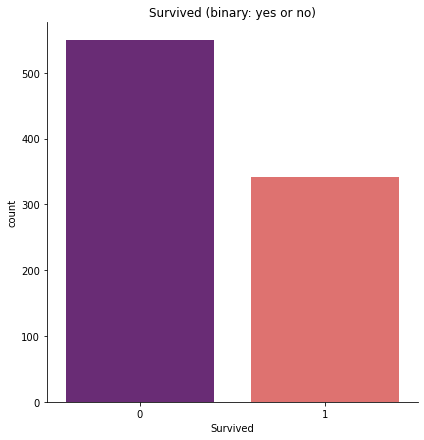

In [8]:
sns.catplot(x="Survived", kind="count",palette="magma", data=titanic_train, height = 6)
plt.title("Survived (binary: yes or no)")

We can see that not everyone died, almost 300 people survived. Thus the classes aren't very imbalanced.

We then create a correlation matrix.
We can observe interesting correlation like between sex and survival or survival and socio-economic status

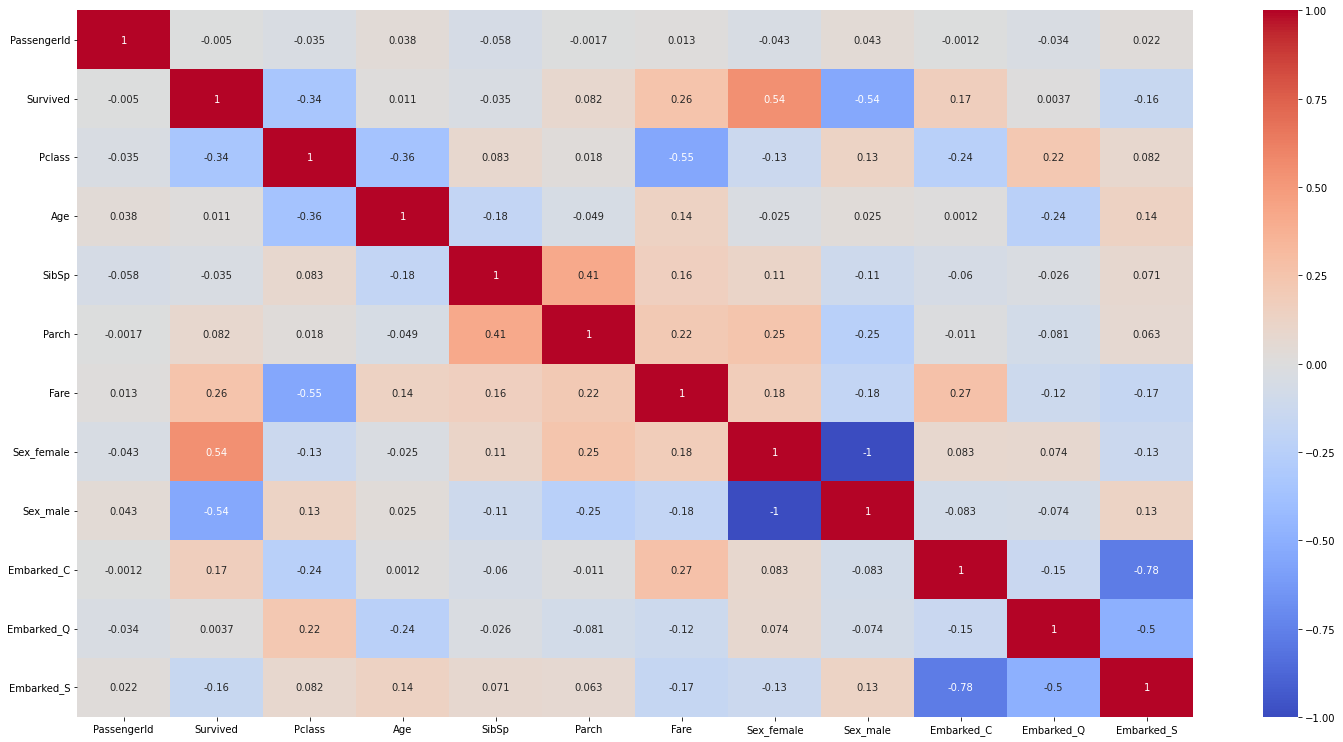

In [9]:
plt.figure(figsize=(25,13))
sns.heatmap(titanic_train.corr(),annot=True,cmap="coolwarm")
plt.show()

# TRAINING

First we'll create our train/test split:


In [10]:
test_ratio = 0.30
Y = titanic_train.Survived

X = titanic_train.drop(['Survived', 'PassengerId'], axis = 1)
X_train, X_val,  Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, random_state=0)


# Baseline method

We will use a perceptron as a first method of prediction

In [11]:
from sklearn.linear_model import Perceptron

model = Perceptron(tol=1e-3, random_state=0)
model.fit(X_train, Y_train)
display(X_train)
Y_train_pred = model.predict(X_train)
print("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))

Y_val_pred = model.predict(X_val)
print("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))




,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
857,1,1.546708,0,0,-0.113846,0,1,0,0,1
52,1,1.432982,1,0,0.896497,1,0,1,0,0
386,3,-1.296431,5,2,0.295895,0,1,0,0,1
124,1,1.717296,0,1,0.907738,0,1,0,0,1
578,3,-1.353294,1,0,-0.357308,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
835,1,0.864354,1,1,1.025945,1,0,1,0,0
192,3,-0.272901,1,0,-0.490280,1,0,0,0,1
629,3,-1.353294,0,0,-0.492714,0,1,0,1,0
559,3,0.693766,1,0,-0.298078,1,0,0,0,1


train accuracy  0.7592295345104334
val accuracy 0.7649253731343284


In [12]:
print(Y_train[:20])
print(Y_train_pred[:20])

857    1
52     1
386    0
124    0
578    0
549    1
118    0
12     0
157    0
127    1
653    1
235    0
785    0
241    1
351    0
862    1
851    0
753    0
532    0
485    0
Name: Survived, dtype: int64
[1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0]


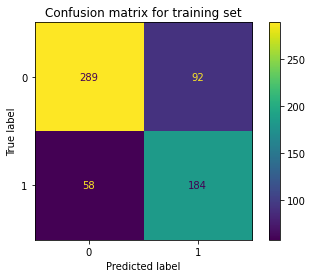

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()


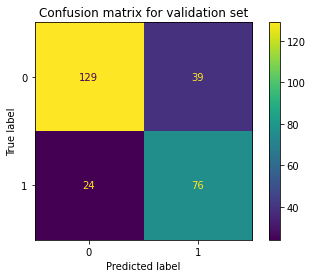

In [14]:

ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)
plt.title('Confusion matrix for validation set' )
plt.show()

writing our prediciton in a CSV

In [15]:
submission = titanic_test
display(titanic_test)
X_test = titanic_test.drop('PassengerId', axis= 1)
display(X_test)
Y_test_pred = model.predict(X_test)
display(X_test)
submission['Survived'] = Y_test_pred
submission.drop(submission.iloc[:, 1:-1], inplace=True, axis=1)
submission = submission.set_index('PassengerId')

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0.594801,0,0,-0.496637,0,1,0,1,0
1,893,3,1.305896,1,0,-0.511497,1,0,0,0,1
2,894,2,2.159209,0,0,-0.463335,0,1,0,1,0
3,895,3,0.168145,0,0,-0.481704,0,1,0,0,1
4,896,3,-0.116293,1,1,-0.416740,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,-1.367819,0,0,-0.492680,0,1,0,0,1
414,1306,1,0.850795,0,0,1.314641,1,0,1,0,0
415,1307,3,0.822352,0,0,-0.507017,0,1,0,0,1
416,1308,3,-1.367819,0,0,-0.492680,0,1,0,0,1


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.594801,0,0,-0.496637,0,1,0,1,0
1,3,1.305896,1,0,-0.511497,1,0,0,0,1
2,2,2.159209,0,0,-0.463335,0,1,0,1,0
3,3,0.168145,0,0,-0.481704,0,1,0,0,1
4,3,-0.116293,1,1,-0.416740,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,-1.367819,0,0,-0.492680,0,1,0,0,1
414,1,0.850795,0,0,1.314641,1,0,1,0,0
415,3,0.822352,0,0,-0.507017,0,1,0,0,1
416,3,-1.367819,0,0,-0.492680,0,1,0,0,1


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.594801,0,0,-0.496637,0,1,0,1,0
1,3,1.305896,1,0,-0.511497,1,0,0,0,1
2,2,2.159209,0,0,-0.463335,0,1,0,1,0
3,3,0.168145,0,0,-0.481704,0,1,0,0,1
4,3,-0.116293,1,1,-0.416740,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,-1.367819,0,0,-0.492680,0,1,0,0,1
414,1,0.850795,0,0,1.314641,1,0,1,0,0
415,3,0.822352,0,0,-0.507017,0,1,0,0,1
416,3,-1.367819,0,0,-0.492680,0,1,0,0,1


In [16]:
submission.to_csv('/kaggle/working/submission.csv')

# Result

This first strategy yields a 0.69856 score for the test set. We can say that we predicted the right outcome for approximately 70% of the passengers.